In [1]:
import obspy
from obspy.core import UTCDateTime, Stats, Trace, Stream
from obspy.taup import TauPyModel
from obspy.geodetics.base import gps2dist_azimuth
import os
from time import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft


# Compute R component

In [2]:
# read event
ev_info = np.loadtxt('data_real_world/EVENTS-INFO/catalog.txt', skiprows=5, delimiter=',', dtype=str)
for number, event_id, datetime, ev_lat, ev_lon, ev_dep, magnitude, magnitude_type, \
    author, flynn_region, mrr, mtt, mpp, mrt, mrp, mtp, stf_func, stf_duration, t1, t2 in ev_info:
    # station info
    st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)
    n_process = 0
    for network, name, loc, ch, st_lat, st_lon, el, dep, _, _, _, _, _, _, _, _, _, _ in st_info:
        tr_name = f'data_real_world/{event_id}/processed/{network}.{name}.{loc}'
        if os.path.exists(f'{tr_name}.BHR') or ch == 'BHE':
            continue
        try:
            # read
            E_trace = obspy.read(f'{tr_name}.BHE')[0]
            N_trace = obspy.read(f'{tr_name}.BHN')[0]
            # rotation
            dist, az, baz = gps2dist_azimuth(float(ev_lat), float(ev_lon), float(st_lat), float(st_lon))
            length = min(len(N_trace.data), len(E_trace.data))
            R_data = np.cos(az) * N_trace.data[:length] + np.sin(az) * E_trace.data[:length]
            R_stats = E_trace.stats.copy()
            R_stats.channel = 'BHR'
            R_stats.npts = length
            R_trace = Trace(R_data, header=R_stats)
            R_trace.write(f'{tr_name}.BHR', format='MSEED')
            n_process += 1
        except FileNotFoundError:
            pass
    if n_process > 0:
        print(f'Done {event_id}: {n_process} BHR computed.')

<ipython-input-2-0d6c481ac7a2>:6: UserWarning: loadtxt: Empty input file: "data_real_world/20150729_023559.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)
<ipython-input-2-0d6c481ac7a2>:6: UserWarning: loadtxt: Empty input file: "data_real_world/20150529_070009.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)
<ipython-input-2-0d6c481ac7a2>:6: UserWarning: loadtxt: Empty input file: "data_real_world/20140925_175117.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)


# Noise database

In [3]:
# %%script echo SKIPPED

# get P traveltime by taup
taup_model = TauPyModel(model="prem")

# filter, slice, resample
fmin = 1 / 200
fmax = 1 / 2
preset = 100
t_pre_P = 30
t_pre_SKS = 200
t_post_SKS = 300
resample_rate = 10

# file to store processed seismograms
fname_noise = 'NOISE@F[%d,%d]R%d' % (1 / fmax, 1 / fmin, resample_rate)
fname_SKS = 'SKS@F[%d,%d]S[%d,%d]R%d' % (1 / fmax, 1 / fmin, t_pre_SKS, t_post_SKS, resample_rate)

# timing
t0 = time()
i_seis = 0

# dict of processed noise
dict_noise = {}
dict_SKS = {}

ev_info = np.loadtxt('data_real_world/EVENTS-INFO/catalog.txt', skiprows=5, delimiter=',', dtype=str)
for number, event_id, datetime, ev_lat, ev_lon, ev_dep, magnitude, magnitude_type, \
    author, flynn_region, mrr, mtt, mpp, mrt, mrp, mtp, stf_func, stf_duration, t1, t2 in ev_info:
    # station info
    st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)
    for network, name, loc, ch, st_lat, st_lon, el, dep, _, _, _, _, _, _, _, _, _, _ in st_info:
        tr_name = f'data_real_world/{event_id}/processed/{network}.{name}.{loc}'
        if not os.path.exists(f'{tr_name}.BHR'):
            continue
        # travel time
        dist, az, baz = gps2dist_azimuth(float(ev_lat), float(ev_lon), float(st_lat), float(st_lon))
        arrivals = taup_model.get_travel_times(
            source_depth_in_km=float(ev_dep), 
            distance_in_degree=np.degrees(dist / 6371e3), 
            phase_list=['P', 'Pdiff', 'SKS'])
        if(len(arrivals) != 2):
            # P or SKS not found
            i_seis += 1
            continue
        assert arrivals[0].name in ['P', 'Pdiff']
        assert arrivals[1].name == 'SKS'
        tP = arrivals[0].time
        tSKS = arrivals[1].time
        # read
        st_trace = obspy.read(f'{tr_name}.BHR')[0]
        
        # filter
        st_trace.filter('bandpass', freqmin=fmin, freqmax=fmax)

        # slice
        st_noise = st_trace.slice(UTCDateTime(t1), 
                                  UTCDateTime(t1) + 100 + tP - t_pre_P)
        st_SKS = st_trace.slice(UTCDateTime(t1) + 100 + tSKS - t_pre_SKS, 
                                UTCDateTime(t1) + 100 + tSKS + t_post_SKS)
        if len(st_SKS) == 0 or len(st_noise) == 0:
            continue
        
        # resample
        st_noise = st_noise.resample(sampling_rate=resample_rate)
        st_SKS = st_SKS.resample(sampling_rate=resample_rate)
        length = len(st_SKS) // 100 * 100
        assert length == 5000
        
        # compute SNR
        if length > len(st_noise):
            continue
            
        data_noise = st_noise.data[(len(st_noise) - length) // 2:][:length]
        data_SKS = st_SKS.data[:length]
        snr = np.sum(data_SKS ** 2) / np.sum(data_noise ** 2)
        
        # save
        dict_noise[f'{event_id}_{network}.{name}.{loc}'] = [st_noise.data, snr]
        dict_SKS[f'{event_id}_{network}.{name}.{loc}'] = [data_SKS, snr]
            
        # timing
        i_seis += 1
        elapsed = round(time() - t0)
        print(f'Done {i_seis}; elapsed={elapsed}', end='\r')

# save
with open('data_real_world/processed/%s.pkl' % fname_noise, 'wb') as f:
    pickle.dump(dict_noise, f)
    
with open('data_real_world/processed/%s.pkl' % fname_SKS, 'wb') as f:
    pickle.dump(dict_SKS, f)    

<ipython-input-3-f4f6d9064ed4>:31: UserWarning: loadtxt: Empty input file: "data_real_world/20150729_023559.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)


<ipython-input-3-f4f6d9064ed4>:31: UserWarning: loadtxt: Empty input file: "data_real_world/20150529_070009.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)


<ipython-input-3-f4f6d9064ed4>:31: UserWarning: loadtxt: Empty input file: "data_real_world/20140925_175117.a/info/station_event"
  st_info = np.loadtxt(f'data_real_world/{event_id}/info/station_event', delimiter=',', dtype=str)


# Prepare a data point

In [4]:
def curve_to_image(curve, fs=10, nperseg=100, noverlap=90, nfft=4000, truncate_nfft=300):
    f, t, Zxx = stft(curve, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, 
                     detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1)
    return f[:truncate_nfft], t, Zxx[:truncate_nfft, :]

def image_to_curve(image, fs=10, nperseg=100, noverlap=90, nfft=4000):
    return istft(image, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft, 
                 input_onesided=True, boundary=True, time_axis=-1, freq_axis=-2)

In [5]:
# load synthetic data
with open('synthetics/processed/SKS@F[2,200]S[200,300]R10.pkl', 'rb') as f:
    dict_synth = pickle.load(f)
    
# load noise
with open('data_real_world/processed/noise@F[2,200]R10.pkl', 'rb') as f:
    dict_noise = pickle.load(f)

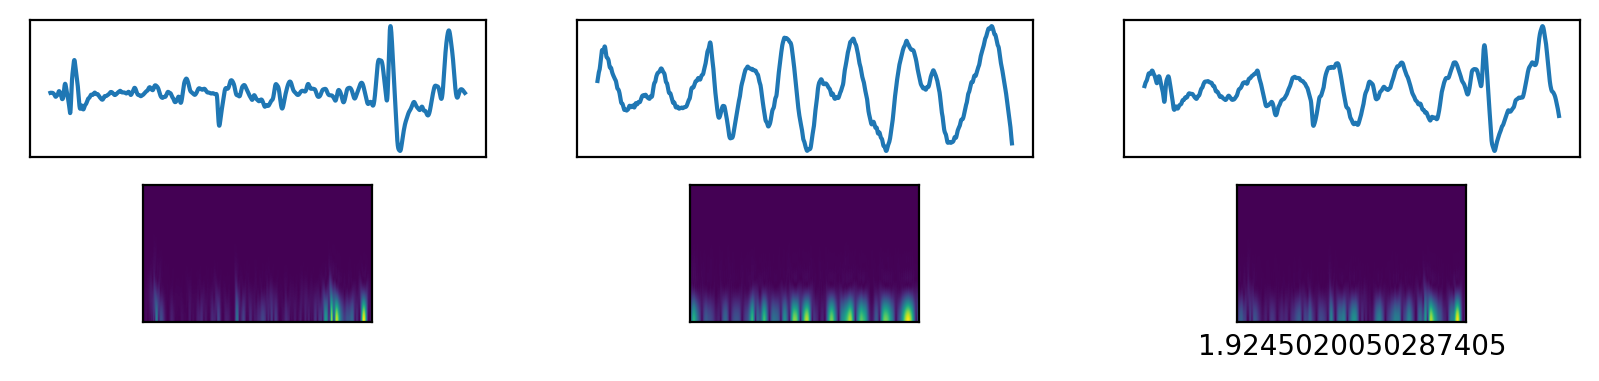

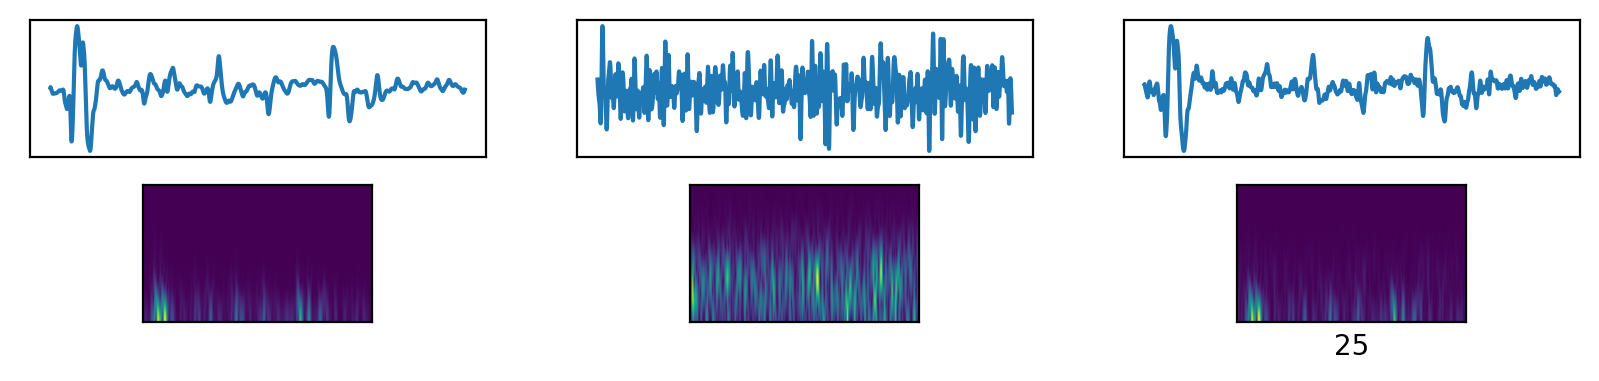

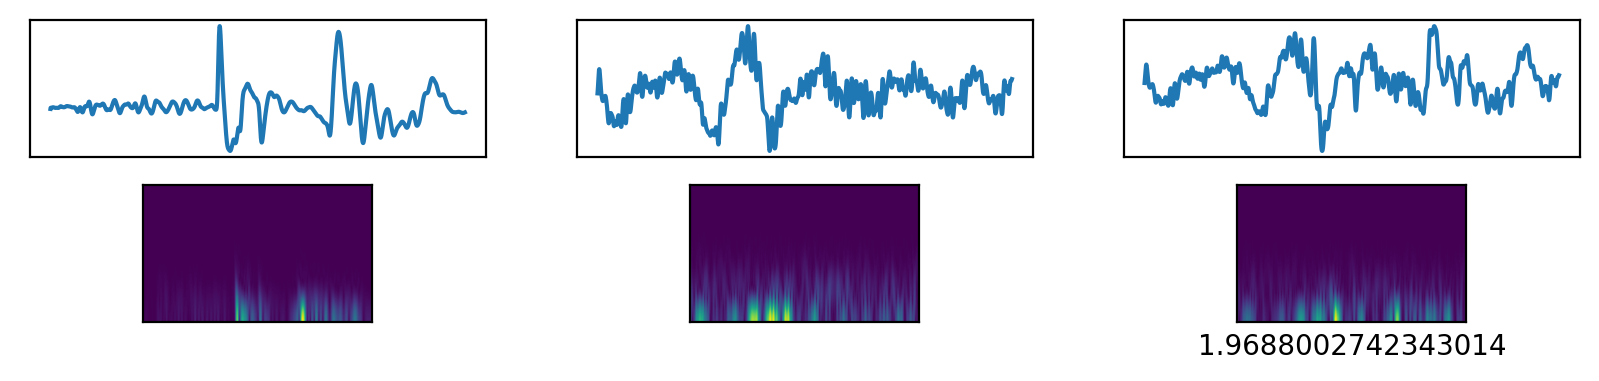

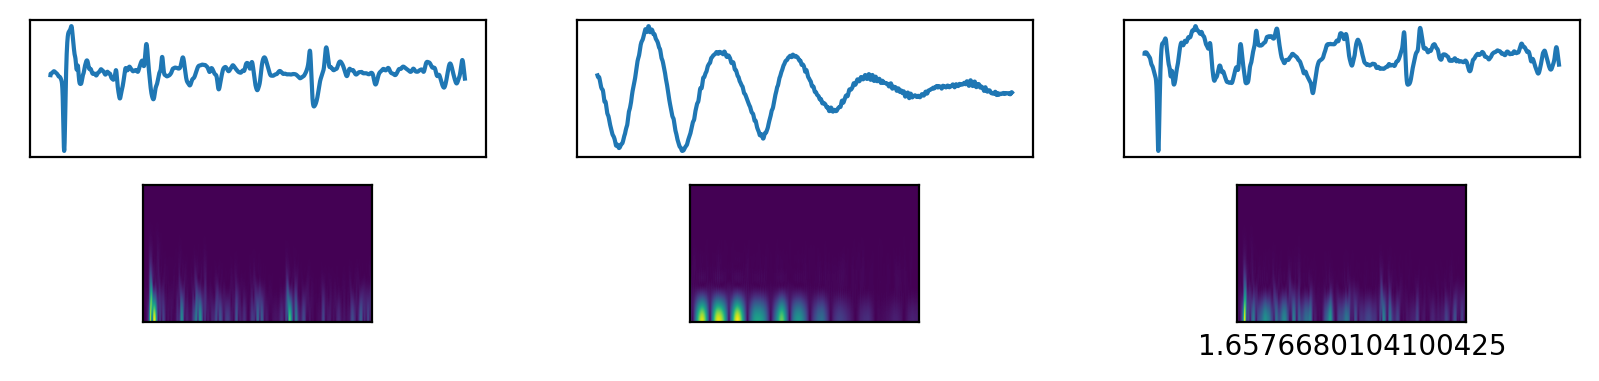

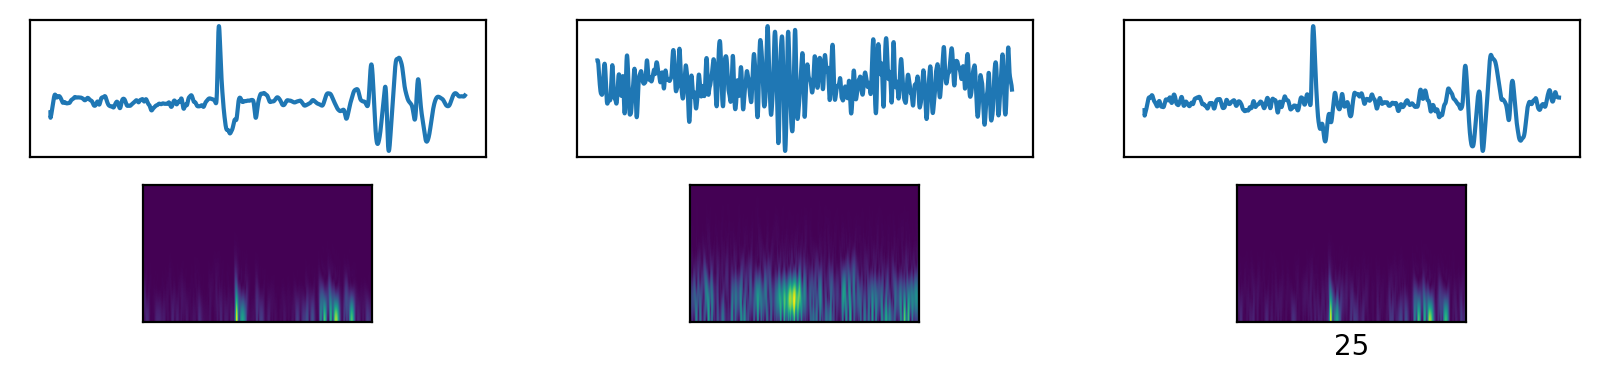

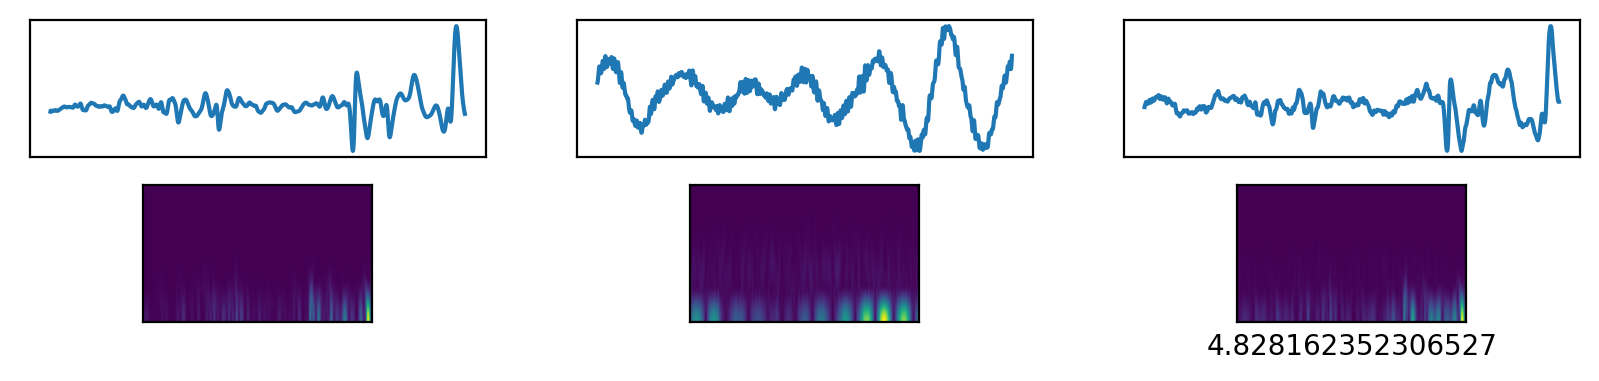

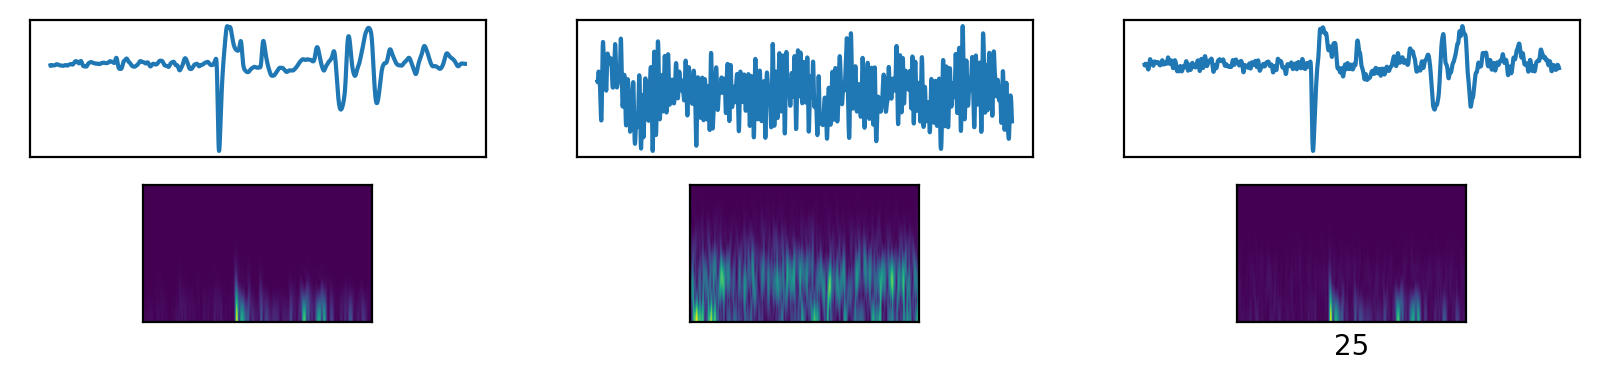

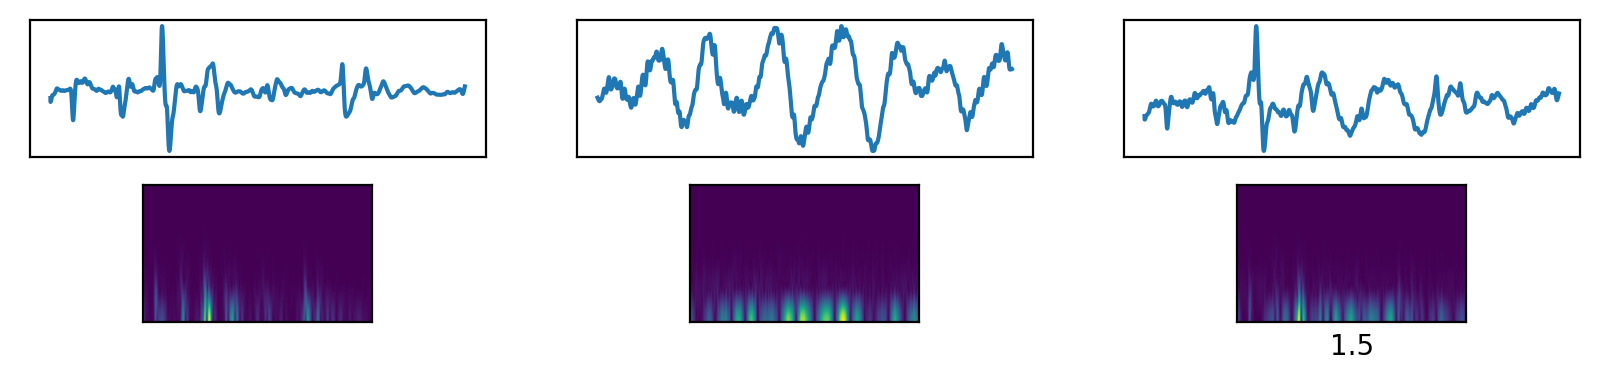

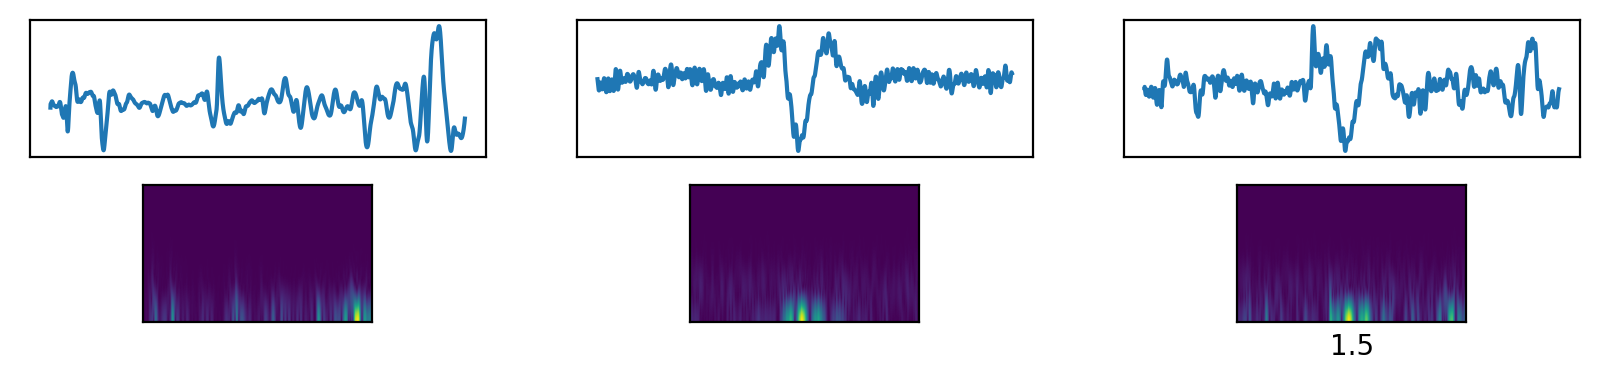

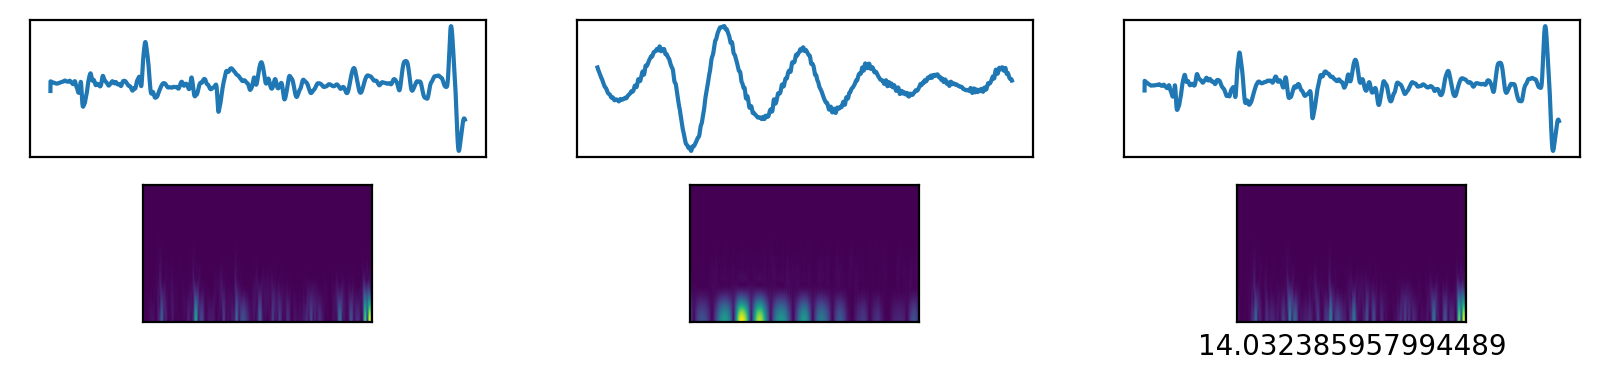

In [6]:
# total number of data for training
n_data_points = 10
snr_min = 1.5
snr_max = 25
data_success = []

while len(data_success) < n_data_points:
    # randomly select a synthetic
    syn_index = np.random.randint(0, len(dict_synth))
    syn, depth, dist = list(dict_synth.values())[syn_index]
    syn /= np.max(np.abs(syn))  # to [0, 1]

    # randomly select a noise
    noise_index = np.random.randint(0, len(dict_noise))
    noise, snr = list(dict_noise.values())[noise_index]

    # randomly take a section of noise that has the same length as syn
    noise_start_index = np.random.randint(0, len(noise) - len(syn))
    noise_section = noise[noise_start_index:][:len(syn)]
    noise_section /= np.max(np.abs(noise_section))  # to [0, 1]

    # randomly purterb snr a little bit
    snr_rand = snr * np.random.uniform(0.75, 1.33)
    if snr_rand > snr_max:
        snr_rand = snr_max
    if snr_rand < snr_min:
        snr_rand = snr_min
    
    # compute the factor F such that 
    # |F * noise + syn|^2 = snr_rand * |F * noise|^2
    n2 = (np.dot(noise_section, noise_section))
    s2 = (np.dot(syn, syn))
    sn = (np.dot(syn, noise_section))
    a = (1 - snr_rand) * n2
    b = 2 * sn
    c = s2
    delta = b ** 2 - 4 * a * c
    if delta < 0:
        # give up this combination
        continue
    F1 = (-b + np.sqrt(delta)) / (2 * a)
    F2 = (-b - np.sqrt(delta)) / (2 * a)
    assert min(F1, F2) < 0
    F = max(F1, F2)
    
    # noised synthetic
    noised_syn = F * noise_section + syn
    
    # to images
    f, t, image_in = curve_to_image(noised_syn)
    f, t, image_out = curve_to_image(syn)    
    f, t, image_noise = curve_to_image(noise_section)    
    
    #####################
    # DATA for TRAINING #
    #####################
    # image_in: input of NN
    # image_out: output of NN
    # depth: condition (maybe used or not)
    # dist: condition (maybe used or not)
    # snr_norm: condition (always use)
    snr_norm = snr_rand / snr_max
    data_success.append((image_in, image_out, depth, dist, snr_norm))
    
    # plot
    fig, ax = plt.subplots(2, 3, dpi=200, figsize=(10, 2))
    for axes in ax:
        for axis in axes:
            axis.set_xticks([])
            axis.set_yticks([])
        
    ax[0, 0].plot(syn)
    ax[0, 1].plot(noise_section)
    ax[0, 2].plot(noised_syn)
    ax[1, 0].imshow(np.abs(image_out), origin='lower')
    ax[1, 1].imshow(np.abs(image_noise), origin='lower')
    ax[1, 2].imshow(np.abs(image_in), origin='lower')
    ax[1, 2].set_xlabel(f'{snr_rand}')
    plt.show()
    